In [1]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/imdb-review-dataset/imdb_master.csv


In [2]:
data=pd.read_csv("../input/imdb-review-dataset/imdb_master.csv",encoding="ISO-8859-1")
data=data.sample(frac=1,random_state=42) #shuffling our data

In [3]:
data.head(15)

,Unnamed: 0,type,review,label,file
75721,75721,train,CAVITE is an example of ultimate independent f...,unsup,3314_0.txt
80184,80184,train,"Decades ago, a crate filled with weapons grade...",unsup,37167_0.txt
19864,19864,test,This is one creepy underrated Gem with chillin...,pos,5379_8.txt
76699,76699,train,Aside from the gross factual inaccuracies of t...,unsup,3402_0.txt
92991,92991,train,The special effects again are superb but this ...,unsup,48694_0.txt
76434,76434,train,i was pretty captivated by the story - i think...,unsup,33792_0.txt
84004,84004,train,Dr Dollitle 2 was a fairly good movie with a s...,unsup,40604_0.txt
80917,80917,train,Not a great film. But then it does not deserve...,unsup,37827_0.txt
60767,60767,train,"In 1941, in the small town of Peyton Place, Mi...",unsup,19692_0.txt
50074,50074,train,"If you like the Comic, you will like the film....",unsup,10067_0.txt


In [4]:
from tqdm import tqdm
import re
data["review"]=[re.sub("[^a-zA-Z]"," ",each) for each in tqdm(data.review, position=0)]#cleaning from symbols and numbers
data.review=[each.lower() for each in tqdm(data.review,position=0)]#low cased every text in data
data.head(10)

100%|██████████| 100000/100000 [00:00<00:00, 386078.26it/s]


,Unnamed: 0,type,review,label,file
75721,75721,train,cavite is an example of ultimate independent f...,unsup,3314_0.txt
80184,80184,train,decades ago a crate filled with weapons grade...,unsup,37167_0.txt
19864,19864,test,this is one creepy underrated gem with chillin...,pos,5379_8.txt
76699,76699,train,aside from the gross factual inaccuracies of t...,unsup,3402_0.txt
92991,92991,train,the special effects again are superb but this ...,unsup,48694_0.txt
76434,76434,train,i was pretty captivated by the story i think...,unsup,33792_0.txt
84004,84004,train,dr dollitle was a fairly good movie with a s...,unsup,40604_0.txt
80917,80917,train,not a great film but then it does not deserve...,unsup,37827_0.txt
60767,60767,train,in in the small town of peyton place mi...,unsup,19692_0.txt
50074,50074,train,if you like the comic you will like the film ...,unsup,10067_0.txt


In [5]:
test=data[data.type=="test"]
test.drop(["type","Unnamed: 0","file"],axis=1,inplace=True)
train=data[data.type=="train"]
train.drop(["type","Unnamed: 0","file"],axis=1,inplace=True)
train=train[train["label"].str.contains("unsup") == False]#drop unsup ones
train.label=[0 if each=="neg" else 1 for each in train["label"]]
test.label=[0 if each=="neg" else 1 for each in test["label"]]
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [6]:
test.head(15)

,review,label
0,this is one creepy underrated gem with chillin...,1
1,death camp opera right here right now br ...,1
2,this film tells the stories of several couples...,1
3,imagine yourself trapped inside a museum of th...,0
4,i just caught this on showtime ewwwwwww not...,0
5,i lay the blame for the comebacks on anyone wh...,0
6,who do you dream of hoot gibson howdy do...,1
7,this was a very good ppv but like wrestlemani...,1
8,we really liked this movie it wasn t trying t...,1
9,rachel and chuck yoman valerie harper gerald...,1


In [7]:
#we gonna use this examples for check one by one at the end of our code
positive_example=test.review[0]
positive_example2=test.review[1]
positive_example3=test.review[2]
positive_example4=test.review[6]

negative_example=test.review[3]
negative_example2=test.review[4]
negative_example3=test.review[5]
negative_example4=test.review[14]

In [8]:
train.tail()

,review,label
24995,the infamous ed wood classic plan from out...,0
24996,first off i would like to point out that the ...,0
24997,this was my favourite film as a child and i h...,1
24998,this movie is why i found this website i coul...,1
24999,this a fascinatingly awful movie it make so l...,0


In [9]:
x_train,y_train,x_test,y_test=train.review,train.label,test.review,test.label

In [10]:

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding, TextVectorization,Dropout
vocab_size = 5000
encoder = TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(x_train)

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie',
       'but', 'film', 't', 'you', 'on', 'not', 'he', 'are', 'his', 'have',
       'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from',
       'like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has',
       'what'], dtype='<U16')

In [12]:
delist=range(1,19) #delisting  '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br'

In [13]:
example="problem film thought pretty good actual lapd crime scene video disturbed wonder lion gate really thought general viewing audience would want see people brutally beaten death blood place sorry lion gate incredibly bad idea br br getting back film cast excellent especially val kilmer late john holmes john holmes sleaze mistreats woman life lisa kudrow wife kate bosworth girlfriend hopelessly deep drug connection eddie nash eric bogosian creates spiral resulted infamous wonderland murder exactly much holmes involved murder may never know entire truth story nash still alive free man film pretty good job nonetheless"

In [14]:
encoded_example = encoder(example).numpy()
encoded_example

array([ 436,   21,  196,  184,   51,  767,    1,  809,  135,  367, 4007,
        584, 2871,    1,   66,  196,  795,  813,  301,   62,  182,   67,
         79, 4646, 3580,  334,  524,  270,  789, 2871,    1,  947,   77,
        323,    8,    8,  391,  145,   21,  178,  320,  258,    1,    1,
        514,  298, 2902,  298, 2902,    1,    1,  241,  111, 2620,    1,
        312, 1752,    1,  932,    1,  909, 1378, 2012, 1703,    1, 1943,
          1, 2099,    1,    1, 3127,    1,  570,  607,   75, 2902,  563,
        570,  200,  115,  123,  433,  859,   64,    1,  132, 1213,  861,
        126,   21,  184,   51,  290, 2892])

In [15]:
for n in range(0,len(encoded_example)):
    print("".join(vocab[encoded_example[n]]),end=" ")

problem film thought pretty good actual [UNK] crime scene video disturbed wonder lion [UNK] really thought general viewing audience would want see people brutally beaten death blood place sorry lion [UNK] incredibly bad idea br br getting back film cast excellent especially [UNK] [UNK] late john holmes john holmes [UNK] [UNK] woman life lisa [UNK] wife kate [UNK] girlfriend [UNK] deep drug connection eddie [UNK] eric [UNK] creates [UNK] [UNK] infamous [UNK] murder exactly much holmes involved murder may never know entire truth story [UNK] still alive free man film pretty good job nonetheless 

In [16]:
#converting our sentences to number lists

number_of_train=[np.setdiff1d(encoder(each).numpy(),[delist]) for each in tqdm(x_train,position=0)]
number_of_test=[np.setdiff1d(encoder(each).numpy(),[delist]) for each in tqdm(x_test,position=0)]

100%|██████████| 25000/25000 [02:08<00:00, 194.36it/s]


In [17]:
number_of_train[0]

array([  19,   20,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   36,   37,   38,   40,   41,   44,   45,   47,
         52,   53,   57,   59,   60,   61,   62,   65,   66,   70,   72,
         73,   77,   80,   81,   82,   83,   87,   91,   94,   97,   98,
        100,  101,  109,  111,  113,  118,  120,  121,  123,  127,  130,
        133,  134,  136,  144,  147,  148,  155,  161,  165,  166,  168,
        172,  179,  181,  189,  203,  218,  223,  230,  232,  252,  261,
        267,  275,  278,  304,  305,  307,  335,  339,  341,  362,  370,
        375,  379,  381,  400,  433,  457,  458,  459,  495,  505,  512,
        519,  523,  531,  537,  573,  576,  580,  581,  615,  629,  672,
        808,  860,  873,  884,  885,  933,  965, 1047, 1065, 1070, 1097,
       1116, 1122, 1128, 1188, 1272, 1438, 1447, 1454, 1492, 1608, 1631,
       1635, 1655, 1669, 1728, 1765, 1876, 1897, 1951, 2056, 2075, 2088,
       2206, 2241, 2282, 2304, 2350, 2464, 2466, 24

In [18]:
#seting each sentence to 150 words for our rnn
maxlen=150
number_of_train=pad_sequences(number_of_train, maxlen=maxlen)
number_of_test=pad_sequences(number_of_test,maxlen=maxlen)

In [19]:
number_of_train[0]

array([  47,   52,   53,   57,   59,   60,   61,   62,   65,   66,   70,
         72,   73,   77,   80,   81,   82,   83,   87,   91,   94,   97,
         98,  100,  101,  109,  111,  113,  118,  120,  121,  123,  127,
        130,  133,  134,  136,  144,  147,  148,  155,  161,  165,  166,
        168,  172,  179,  181,  189,  203,  218,  223,  230,  232,  252,
        261,  267,  275,  278,  304,  305,  307,  335,  339,  341,  362,
        370,  375,  379,  381,  400,  433,  457,  458,  459,  495,  505,
        512,  519,  523,  531,  537,  573,  576,  580,  581,  615,  629,
        672,  808,  860,  873,  884,  885,  933,  965, 1047, 1065, 1070,
       1097, 1116, 1122, 1128, 1188, 1272, 1438, 1447, 1454, 1492, 1608,
       1631, 1635, 1655, 1669, 1728, 1765, 1876, 1897, 1951, 2056, 2075,
       2088, 2206, 2241, 2282, 2304, 2350, 2464, 2466, 2489, 2755, 2776,
       2823, 2900, 3080, 3123, 3200, 3249, 3349, 3403, 3550, 3572, 3797,
       3834, 3950, 4169, 4195, 4410, 4662, 4930], d

In [20]:
num_words=len(encoder.get_vocabulary())

In [21]:
#a simple RNN
model = Sequential([
    
    Embedding(num_words,32,mask_zero=True),
    Bidirectional(LSTM(16)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [24]:
history=model.fit(number_of_train,y_train,epochs=10,batch_size=128,validation_data=(number_of_test,y_test),validation_steps=30)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.6002 - loss: 0.9383 - val_accuracy: 0.8612 - val_loss: 0.4166
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.8872 - loss: 0.3229 - val_accuracy: 0.8674 - val_loss: 0.3649
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9051 - loss: 0.2805 - val_accuracy: 0.8737 - val_loss: 0.4324
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9166 - loss: 0.2463 - val_accuracy: 0.8633 - val_loss: 0.4681
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.9249 - loss: 0.2367 - val_accuracy: 0.8815 - val_loss: 0.6355
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9377 - loss: 0.2007 - val_accuracy: 0.8206 - val_loss: 0.9351
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9414 - loss: 0.2146 - val_accuracy: 0.7230 - val_loss: 0.5876
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.8821 - loss: 0

In [25]:
# تقييم النموذج على بيانات الاختبار
loss, accuracy = model.evaluate(number_of_test, y_test)

# طباعة النتيجة النهائية
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8454 - loss: 1.0123
Final Loss: 1.0303
Final Accuracy: 0.8449


(0.0, 1.0209403723478316)

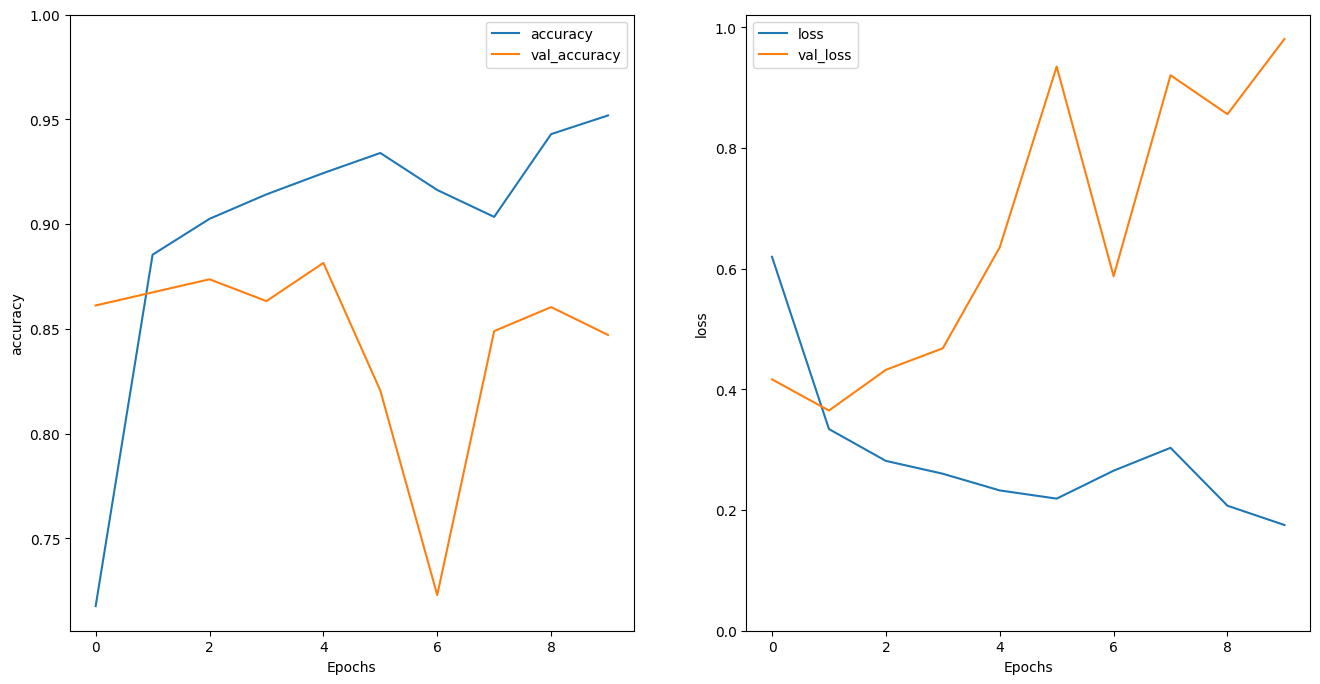

In [26]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [27]:
sample_text = ('the movie was not good. the animation and the graphics were terrible. I would not recommend this movie.')
positive_text=("the movie was good, we enjoyed it with family, it was pretty fun")
def decide(text):
    text=np.setdiff1d(encoder(text).numpy(),[delist])
    text=pad_sequences([text],maxlen=maxlen)
    prediction = model.predict(text)
    print("Prediction Score: ",prediction)
    if prediction>0.5:print("This is an positive review")
    else:print("This is an negative review")
        
        
decide(sample_text)
decide(positive_text)
print()
print("*"*20+"POSITIVES"+"*"*20)
decide(positive_example)
decide(positive_example2),
decide(positive_example3)
decide(positive_example4)
print()
print("*"*20+"NEGATIVES"+"*"*20)
decide(negative_example)
decide(negative_example2)
decide(negative_example3)
decide(negative_example4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Prediction Score:  [[0.07496899]]
This is an negative review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction Score:  [[0.22965407]]
This is an negative review

********************POSITIVES********************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[1.1107856]]
This is an positive review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[1.0376407]]
This is an positive review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction Score:  [[1.3175778]]
This is an positive review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction Score:  [[1.1294934]]
This is an positive review

********************NEGATIVES********************
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[-0.02347663]]
This is an negative review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction Score:  [[-0.24044944]]
This is an negative review
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[0.3116745]]
This is an negative review
1/1 ━━━━━

In [28]:
#a negative review example from google
decide("This film has got to be the epitome of terrible writing and should be a classroom example of 'what not to do' when writing a screenplay. Why would Joshua take on (clearly) amateur writer Adam Gaines script is beyond me. Even his good directing and excellent cinematography could not save this disaster.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[-0.17081244]]
This is an negative review


In [29]:
#a positive review example from google
decide(" It is a limited budget Indie action film that has the look, feel, and heartfelt acting of a high-quality big budget movie. Katia Winter gives Academy Award worthy performance. Would be terrific to see on the big screen. No spoilers. Just sit back and enjoy as the story unfolds. Would Rate as 12 if possible.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction Score:  [[1.1286846]]
This is an positive review
